# 1. Imports

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 2. Data

only works under "TensorFlow-Tutorials-master"

In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

show data features and shapes

In [3]:
print('data.img_size:\t\t{}'.format(data.img_size))
print('data.img_size_flat:\t{}'.format(data.img_size_flat))
print('data.img_shape:\t\t{}'.format(data.img_shape))
print('data.num_classes:\t{}'.format(data.num_classes))
print('data.num_channels:\t{}'.format(data.num_channels))

data.img_size:		28
data.img_size_flat:	784
data.img_shape:		(28, 28)
data.num_classes:	10
data.num_channels:	1


show subsets.validation_data is not used

In [4]:
print('train_data:\t\t{}'.format(data.num_train))
print('validation_data:\t{}'.format(data.num_val))
print('test_data:\t\t{}'.format(data.num_test))

train_data:		55000
validation_data:	5000
test_data:		10000


# 3. Placeholders

only inputs and outputs which will be fed are considered as placeholders. image inputs and class outputs are considered as layers.

x is in flat, and y is in one-hot.

In [5]:
x = tf.placeholder(tf.float32, shape = [None, data.img_size_flat])
print('x in flat:', x.shape)
y = tf.placeholder(tf.float32, shape = [None, data.num_classes])
print('y in one-hot:', y.shape)

x in flat: (?, 784)
y in one-hot: (?, 10)


# 4. Functions

## 4.1 Data functions 

some notations of data:
    
    d: data
    n: number of data
    sh: shap of data
    f: number of features
    ch: number of channels


notations of functions
    
    n_: create a new object
    t_: transform a object. usually the outputs are values of the object
    g_: get attributes of a object. usually the outputs are not values of the object

descrition of following functions:
    
    g_n: get number of data
    g_f_sh: get feature shape
    g_f: get number if features
    g_ch: get number of channels

.value is for objects which are tensors or variables

In [6]:
def g_n(d):
    n = d.shape[:1]
    return n

def g_f_sh(d):
    f_sh = d.shape[1:]
    return f_sh

def g_f(d):
    f_sh = g_f_sh(d)
    f = np.prod(f_sh)
    f = f.value
    return f

def g_ch(d):
    f_sh = g_f_sh(d)
    ch = f_sh[-1]
    ch = ch.value
    return ch


## 4.2 Weights and biases funtions 

descrition of following functions:
    
    n_w: create a weights variable
    n_b: create a biases variable
    n_fc_w_b: create a weights variable and a biases variable for a full connected neural network
        i_f: number of input features 
        nr: number of neurons
    n_cnn_2d_w_b: create a weights variable and a biases variable for 2d convolutional neural network.

notations of 2d filter:
    
    ft: filter
    ft_s: filter size, if filter is in square
    ft_x: filter size of x axis
    ft_y: filter size of y axis
    i_ch: number of input channels
    o_ch: number of putpuy channels

In [7]:
def n_w(sh):
    w = tf.Variable(tf.truncated_normal(dtype = tf.float32, shape = sh, stddev = 0.05))
    return w

def n_b(sh):
    b = tf.Variable(tf.constant(dtype = tf.float32, shape = sh, value = 0.05))
    return b

def n_fc_w_b(i_f, nr):
    w = n_w([i_f, nr])
    b = n_b([nr])
    return w, b

def n_cnn_2d_w_b(ft_x, ft_y, i_ch, o_ch):
    w = n_w([ft_x, ft_y, i_ch, o_ch])
    b = n_b([o_ch])
    return w, b

## 4.3 Layer funtions 

description of following functions:
    
    t_fltn: flatten data
    n_fc: create a fc layer
    n_cnn_2d: create a 2d cnn

notation of outputs of layer funtions
    
    o: outputs will be send to the next layer
    w: weights of the layer
    b: biases of the layer

In [8]:
def t_fltn(d):
    f = g_f(d)
    d = tf.reshape(d, [-1, f])
    return d

In [9]:
def n_fc(i, nr_n, relu = True):
    
    i_f = g_f(i)
    w, b = n_fc_w_b(i_f, nr_n)
    o = tf.matmul(i, w) + b
    
    if relu == True:
        o = tf.nn.relu(o)
    
    return o, w, b

In [10]:
def n_cnn_2d(i, ft_x, ft_y, o_ch, pool = 1, relu = True):
    
    i_ch = g_ch(i)
    w, b = n_cnn_2d_w_b(ft_x, ft_y, i_ch, o_ch)
    o = tf.nn.conv2d(i, w, strides = [1,1,1,1], padding = 'SAME') + b
    
    if pool > 1:
        o = tf.nn.max_pool(value = o, ksize = [1, pool, pool, 1], strides = [1, pool, pool, 1], padding = 'SAME' )
    
    if relu == True:
        o = tf.nn.relu(o) 
    
    return o, w, b

# 5 Models

##  5.1 Neuron network layers

process of following layers:
    
    x and y : not shown here, the placeholders defined above,
    x_img: transformed x into images with format of (28, 28, 1)
    cnn1_o: scan each image of x_img with filter of (5,5), and creates 16 new images of (14, 14)
    cnn2_o: scan each set of 16 images of cnn1_o with filter of (5,5), and creates 36 images of (7, 7)
    cnn2_o_fltn: flatten cnn2_o into 1,764 (7 * 7 * 36)
    fc1_o: go through a fc with 128 neurons
    p: go through another of with 10 reurons to get class predictions. note relu is not uesed here

In [11]:
x_img = tf.reshape(x, shape = [-1, data.img_shape[0], data.img_shape[1], data.num_channels])
print('x in image:', x_img.shape)

cnn1_o, cnn1_w, cnn1_b = n_cnn_2d(x_img, 5, 5, 16, pool = 2)
print('cnn1:',cnn1_o, cnn1_w, cnn1_b)

cnn2_o, cnn2_w, cnn2_b = n_cnn_2d(cnn1_o, 5, 5, 36, pool = 2)
print('cnn2:',cnn2_o, cnn2_w, cnn2_b)

cnn2_o_fltn = t_fltn(cnn2_o)
print('cnn2 in flat:',cnn2_o_fltn)

fc1_o, fc1_w, fc1_b = n_fc(cnn2_o_fltn, 128)
print('fc1:', fc1_o, fc1_w, fc1_b)

p, fc2_w, fc2_b = n_fc(fc1_o, 10, relu = False)
print('p in probabilities:', p, fc2_w, fc2_b)

x in image: (?, 28, 28, 1)
cnn1: Tensor("Relu:0", shape=(?, 14, 14, 16), dtype=float32) <tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref> <tf.Variable 'Variable_1:0' shape=(16,) dtype=float32_ref>
cnn2: Tensor("Relu_1:0", shape=(?, 7, 7, 36), dtype=float32) <tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref> <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>
cnn2 in flat: Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)
fc1: Tensor("Relu_2:0", shape=(?, 128), dtype=float32) <tf.Variable 'Variable_4:0' shape=(1764, 128) dtype=float32_ref> <tf.Variable 'Variable_5:0' shape=(128,) dtype=float32_ref>
p in probabilities: Tensor("add_3:0", shape=(?, 10), dtype=float32) <tf.Variable 'Variable_6:0' shape=(128, 10) dtype=float32_ref> <tf.Variable 'Variable_7:0' shape=(10,) dtype=float32_ref>


## 5.2 Optimizing layers

In [12]:
c = tf.nn.softmax_cross_entropy_with_logits_v2(logits = p, labels = y)
c = tf.reduce_mean(c)
print('c:', c)

c: Tensor("Mean:0", shape=(), dtype=float32)


In [13]:
op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(c)
print('op:', op)

op: name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/update_Variable_2/ApplyAdam"
input: "^Adam/update_Variable_3/ApplyAdam"
input: "^Adam/update_Variable_4/ApplyAdam"
input: "^Adam/update_Variable_5/ApplyAdam"
input: "^Adam/update_Variable_6/ApplyAdam"
input: "^Adam/update_Variable_7/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



## 5.3  Accuracy layers

descrition of following functions:
    
    t_cls: transform probalilities of one-hot into class values


why does this function exist?

this is a programing style i am trying to develop. i am not programmer, and code is hard for me to understand. what does "tf.argmax(d, axis = 1)" mean? it might has innumerable meanings in innumerable context. but right down here, it have a very definite meaning to me: transform data into class values. "t_cls" tells me.

In [14]:
def t_cls(d):
    d = tf.argmax(d, axis = 1)
    return d

description of following layers:
    
    y_cls: real class values of y
    p_cls: prediction calss values
    
    ac_bl: true of false of the prediction
    ac_f32: cast is needed to transform boolean into float
    ac: finnal average cost

In [15]:
y_cls = t_cls(y)
print('y in class:', y_cls)
p_cls = t_cls(p)
print('p in class:', p_cls)

y in class: Tensor("ArgMax:0", shape=(?,), dtype=int64)
p in class: Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


In [16]:
ac_bl = tf.equal(y_cls, p_cls)
ac_f32 = tf.cast(ac_bl, dtype = tf.float32)
ac = tf.reduce_mean(ac_f32, axis = 0)
print('ac:', ac)

ac: Tensor("Mean_1:0", shape=(), dtype=float32)


# 7. Session

In [17]:
se = tf.Session()
se.run(tf.global_variables_initializer())

# 8. Training and testing functions

## 8.1 Plots functions 

descrition of following function:
    
    plt_img: plot images with real class values and prediction class values
        cl = number of columns
        rw = number of rows
        ax_n: number of axes/imges in a fg
        ax_sh: shape of ax/image

In [18]:
def plt_img(img, y_cls, p_cls, cl = 5):

    print('img.shape:', img.shape)
    
    img_n = img.shape[0]
    img_x = img.shape[1]
    img_y = img.shape[2]
    img_ch = img.shape[3]
    
    ax_sh = [img_x, img_y] # strange, channel is not needed
    ax_n = img_n
    rw = math.ceil(ax_n/cl)
    
    fg, axes = plt.subplots(rw, cl)
    fg.subplots_adjust(hspace = 0.2, wspace = 0.2)
    
    for i, ax in enumerate(axes.flat):
        if i < img_n:
            ax.imshow(img[i].reshape(ax_sh), cmap = 'binary')
            x_lb = 'y:{0} p:{1}'.format(y_cls[i], p_cls[i])
            ax.set_xlabel(x_lb)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show

## 8.2 Train funtions 

descrition of following functions:
    
    def n_bt: create a batch from data
        st: start index
        nd: end index
    
    tr: training function that uses training data to feed optimizer(op)
        i_x: x as inputs
        i_y: y as inputs
        bt_s: batch size
        it: number of iterations
        ep: number if epochs
        it_shw: iterations to show accuracy
        
        i_x_n: number of x
        it_nd: indicates if the current iteration is the last one. if the end index (nd) of current batch reaches number of x, that means later literations don't need to run and the loop should be stopped.
        i_x_bt: x batch
        i_y_bt: y batch
        fd_bt: feed batch contains x batch and y batch

In [19]:
def n_bt(d, st, nd):
    bt = d[st:nd]
    return bt

In [20]:
def tr(i_x, i_y, bt_s = 100, it = 550, ep = 1, it_shw = 100):
    
    for i in range(ep):
        i_x_n = i_x.shape[0]
        it_nd = False
        
        for j in range(0, it):
            st = j * bt_s
            nd = (j + 1) * bt_s
            if nd > i_x_n:
                nd = i_x_n
                it_nd = True
            
            i_x_bt = n_bt(i_x, st, nd)
            i_y_bt = n_bt(i_y, st, nd)
            i_bt = {x: i_x_bt, y: i_y_bt} 
            
            se.run(op, feed_dict = i_bt)
            
            if (j + 1) % it_shw == 0 or it_nd == True:
                cost, accuracy = se.run([c, ac], feed_dict = i_bt)
                print('epochs:{0}\titerations:{1}'.format(i + 1, j + 1))
                print('cost:{0:2f}\taccurcy:{1:0.1%}'.format(cost, accuracy))
            
                if it_nd == True:
                    break
                
        print('epochs:{0} finished'.format(i + 1))    
        
    return 'train finished'

## Test funtions

descrition of following function:
    
    ts: testing funtion that uses testing data to feed accuracy(acc)
        i_x: x as inputs
        i_y: y as inputs
        bt_s: batch size
        show_wrong: if show wrong images
        
        wrong_image, wrong_y, wrong_p: images, real calss values, prediction class values of wrong preditions

In [21]:
def ts(i_x, i_y, bt_s = 10000, show_wrong = False):
    
    if bt_s == 0:
        bt_s = ts_x.shape[0]
    i_x_bt = i_x[:bt_s]
    i_y_bt = i_y[:bt_s]
    
    i_bt = {x: i_x_bt, y: i_y_bt} 
    
    x_image, cost, accuracy, accuracy_bool, y_class, p_class = se.run([x_img, c, ac, ac_bl, y_cls, p_cls], feed_dict = i_bt)
    
    print('cost:{0:2f}\taccurcy:{1:0.1%}'.format(cost, accuracy))
    
    if show_wrong == True: 
        
        wrong = np.where(accuracy_bool == False)
        
        wrong_img = x_image[wrong]
        wrong_y = y_class[wrong]
        wrong_p = p_class[wrong]
    
        plt_img(wrong_img[0:10], wrong_y[0:10], wrong_p[0:10], cl = 5,)
    
    return 'test finished'

# 9. Train and test

In [22]:
tr(data.x_train, data.y_train, 64, 1000, 1, 100)

epochs:1	iterations:100
cost:1.818742	accurcy:54.7%
epochs:1	iterations:200
cost:0.881090	accurcy:68.8%
epochs:1	iterations:300
cost:0.578191	accurcy:81.2%
epochs:1	iterations:400
cost:0.414766	accurcy:89.1%
epochs:1	iterations:500
cost:0.322338	accurcy:89.1%
epochs:1	iterations:600
cost:0.352916	accurcy:89.1%
epochs:1	iterations:700
cost:0.317580	accurcy:87.5%
epochs:1	iterations:800
cost:0.442733	accurcy:85.9%
epochs:1	iterations:860
cost:0.577444	accurcy:87.5%
epochs:1 finished


'train finished'

cost:0.294461	accurcy:91.4%
img.shape: (10, 28, 28, 1)


'test finished'

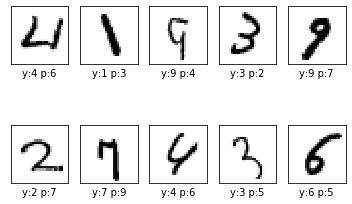

In [23]:
ts(data.x_test, data.y_test, 1000, show_wrong = True)

# 10. Show weights

In [24]:
def plt_cnn_2d_w(w, cl = 5):
    
    w = se.run(w)
    print('w.shape', w.shape)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    ft_x = w.shape[0]
    ft_y = w.shape[1]
    i_ch = w.shape[2]
    o_ch = w.shape[3]
    
    print('i_ch:', i_ch)
    print('o_ch:', o_ch)
    
    ax_n = i_ch * o_ch
    rw = math.ceil(ax_n/cl)
    
    fg, axes = plt.subplots(rw, cl)
    fg.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    j = 0
    k = 0
    
    for i, ax in enumerate(axes.flat):
        if i < ax_n:
            while j in range(i_ch):
                print('j=', j )
                while k in range(o_ch):
                    print('k=', k )
                    img = w[:, :, j, k]
                    x_lb = 'i:{0} o:{1}'.format(j + 1, k + 1)
                    k = k + 1
                j = j + 1
                    
            ax.imshow(img, vmin = w_min, vmax = w_max, interpolation='nearest' , cmap = 'seismic')
            ax.set_xlabel(x_lb)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # what's fucking wrong with loop?!
    plt.show

w.shape (5, 5, 1, 16)
i_ch: 1
o_ch: 16
j= 0
k= 0
k= 1
k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10
k= 11
k= 12
k= 13
k= 14
k= 15


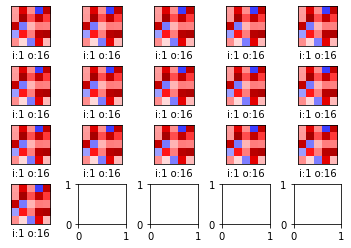

In [25]:
plt_cnn_2d_w(cnn1_w, cl = 5)

# 11. Show outputs

In [26]:
def plt_cnn_2d_o(img, o, cl = 5):
    
    plt.imshow(img.reshape([28, 28]), cmap = 'binary')
    
    fd_img = {x: [img]}
    o = se.run(o, feed_dict = fd_img)
    
    print('o.shape', o.shape)
    
    o_n = o.shape[0]
    o_x = o.shape[1]
    o_y = o.shape[2]
    o_ch = o.shape[3]
    
    ax_sh = [o_x, o_y]
    ax_n = o_ch
    
    rw = math.ceil(ax_n/cl)
    
    fg, axes = plt.subplots(rw, cl)
    fg.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    for i, ax in enumerate(axes.flat):
        if i < ax_n:
            img = o[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap = 'binary')
            x_lb = 'chn:{0}'.format(i+1)
            ax.set_xlabel(x_lb)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show

o.shape (1, 14, 14, 16)


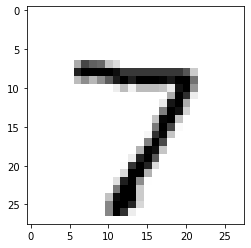

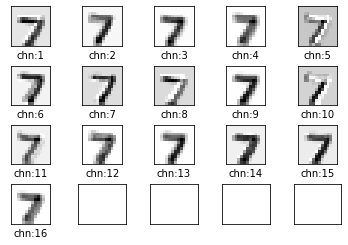

In [27]:
image = data.x_test[0]
plt_cnn_2d_o(image, cnn1_o, cl = 5)